In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torchvision.utils as vutils

from models import Generator, JRelu
from torch_datasets import cat_dl
from utils import show_samples, save_real_batch

In [41]:
def load_generator(weight_path, activation, norm='bn'):
    """Load weights and return a DC Generator. Model remains in train mode
    even at test time.
    """
    G = Generator(act=activation, norm=norm)
    states = torch.load(weight_path)
    G.load_state_dict(states['g'])
    G.train()
    print(f'Weights loaded from {weight_path}.')
    return G

In [155]:
def generate_dc_samples(model, output_dir, fname, samples=64, noise=None,
                        threshold=None):
    """
    Parameters
    -----------
    model: nn.Module
        Generator
    output_dir: str
        Location to save generated samples.
    fname: str
        Name of output image file.
    samples: int
        Number of samples to generate.
    noise: torch.tensor or None
        If None, new random noise will be generated. When generating samples 
        for many different sets of weights, this means we can choose to use 
        the same noise or different noise for each sample.
    threshold: float or None
        If not None, use for post-processing to filter what values should be
        counted as black.
    """
    os.makedirs(output_dir, exist_ok=True)
    path = os.path.join(output_dir, fname)
    if noise is None:
        noise = torch.randn(samples, 100, 1, 1)
    with torch.no_grad():
        fake = model(noise).detach()
    if threshold:
        fake = (fake.mean(0) < thresh).astype(float)
    vutils.save_image(fake, path, normalize=True, 
                      nrow=int(np.sqrt(samples)))
    print(f'Output image saved to {path}.')

In [157]:
def multi_model_samples(weight_paths, output_dir, act, norm='bn', 
                        samples=64, fixed=True, threshold=None):
    if fixed:
        noise = torch.randn(samples, 100, 1, 1)
    else:
        noise = None
    for i, path in enumerate(weight_paths):
        G = load_generator(path, act, norm)
        output_fname = f"{path.split('/')[-1].strip('.pth')}.png"
        generate_dc_samples(G, output_dir, output_fname, samples, noise, 
                            threshold)
        print()

In [4]:
weight_dir = 'cat_samples5'
output_dir = 'cat_samples_misc'
epochs = [5, 6, 7, 8, 10, 12, 13, 14, 15, 31, 41, 44]
fnames = [os.path.join(weight_dir, f'{e}.pth') for e in epochs]

In [158]:
multi_model_samples(fnames, output_dir, JRelu, samples=144)

Weights loaded from cat_samples5/5.pth.
Output image saved to cat_samples_misc/5.png.

Weights loaded from cat_samples5/6.pth.
Output image saved to cat_samples_misc/6.png.

Weights loaded from cat_samples5/7.pth.
Output image saved to cat_samples_misc/7.png.

Weights loaded from cat_samples5/8.pth.
Output image saved to cat_samples_misc/8.png.

Weights loaded from cat_samples5/10.pth.
Output image saved to cat_samples_misc/10.png.

Weights loaded from cat_samples5/12.pth.
Output image saved to cat_samples_misc/12.png.

Weights loaded from cat_samples5/13.pth.
Output image saved to cat_samples_misc/13.png.

Weights loaded from cat_samples5/14.pth.
Output image saved to cat_samples_misc/14.png.

Weights loaded from cat_samples5/15.pth.
Output image saved to cat_samples_misc/15.png.

Weights loaded from cat_samples5/31.pth.
Output image saved to cat_samples_misc/31.png.

Weights loaded from cat_samples5/41.pth.
Output image saved to cat_samples_misc/41.png.

Weights loaded from cat_sampl

### Scratch

In [81]:
G = load_generator(fnames[4], JRelu)
noise = torch.randn(2, 100, 1, 1)
out = G(noise).detach().numpy()

Weights loaded from cat_samples5/10.pth.


In [132]:
pd.value_counts((out[0] < -.75).astype(float).ravel())

0.0    11320
1.0      968
dtype: int64

In [135]:
pd.value_counts(1 - (out[1] < -.95).astype(float).ravel())

1.0    11473
0.0      815
dtype: int64

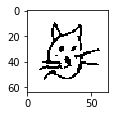

In [154]:
fig, ax = plt.subplots(figsize=(1.5, 1.5))
plt.imshow((out[1].mean(0) < -.5).astype(float), 
           cmap='Greys')
plt.show()

In [15]:
dl = iter(cat_dl)
batch = next(dl)
vutils.save_image(batch[0], f'{output_dir}/real_batch.png', normalize=True)